In [1]:
#======================================================================
#
#     This routine solves an infinite horizon growth model 
#     with dynamic programming and sparse grids
#
#     The model is described in Scheidegger & Bilionis (2017)
#     https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2927400
#
#     external libraries needed:
#     - IPOPT (https://projects.coin-or.org/Ipopt)
#     - PYIPOPT (https://github.com/xuy/pyipopt)
#     - TASMANIAN (http://tasmanian.ornl.gov/)
#
#     Simon Scheidegger, 11/16 ; 07/17
#======================================================================

import nonlinear_solver_initial as solver     #solves opt. problems for terminal VF
import nonlinear_solver_iterate as solviter   #solves opt. problems during VFI
import nonlinear_solver_iterate as solveriter   #solves opt. problems during VFI
from parameters import *                      #parameters of model
#import interpolation as interpol              #interface to sparse grid library/terminal VF
#import interpolation_iter as interpol_iter    #interface to sparse grid library/iteration
import postprocessing as post                 #computes the L2 and Linfinity error of the model

import TasmanianSG                            #sparse grid library
import numpy as np
#======================================================================

In [42]:
#======================================================================
#
#     This routine interfaces with the TASMANIAN Sparse grid
#     The crucial part is 
#
#     aVals[iI]=solver.initial(aPoints[iI], n_agents)[0]  
#     => at every gridpoint, we solve an optimization problem
#
#     Simon Scheidegger, 11/16 ; 07/17
#======================================================================

#import TasmanianSG
#import numpy as np
#from parameters import *
#import nonlinear_solver_initial as solver

#======================================================================

def sparse_grid(n_agents, iDepth):
    
    grid  = TasmanianSG.TasmanianSparseGrid()

    k_range=np.array([k_bar, k_up])

    ranges=np.empty((n_agents, 2))


    for i in range(n_agents):
        ranges[i]=k_range

    iDim=n_agents

    grid.makeLocalPolynomialGrid(iDim, iOut, iDepth, which_basis, "localp")
    grid.setDomainTransform(ranges)

    aPoints=grid.getPoints()
    iNumP1=aPoints.shape[0]
    aVals=np.empty([iNumP1, 1])
    
    file=open("comparison0.txt", 'w')
    for iI in range(iNumP1):
        aVals[iI]=solver.initial(aPoints[iI], n_agents)[0] 
        v=aVals[iI]*np.ones((1,1))
        to_print=np.hstack((aPoints[iI].reshape(1,n_agents), v))
        np.savetxt(file, to_print, fmt='%2.16f')
        
    file.close()
    grid.loadNeededPoints(aVals)
    
    f=open("grid.txt", 'w')
    np.savetxt(f, aPoints, fmt='% 2.16f')
    f.close()
    
    return grid

def adap_sparse_grid(n_agents, iDepth):
    
    grid  = TasmanianSG.TasmanianSparseGrid()

    k_range=np.array([k_bar, k_up])

    ranges=np.empty((n_agents, 2))


    for i in range(n_agents):
        ranges[i]=k_range

    iDim=n_agents

    refinement_level = 5 #NEW
    fTol = 1.E-5 #NEW    
    
    grid.makeLocalPolynomialGrid(iDim, iOut, iDepth, which_basis, "localp")
    grid.setDomainTransform(ranges)

    aPoints=grid.getPoints()
    iNumP1=aPoints.shape[0]
    aVals=np.empty([iNumP1, 1])
    
    ##new block for adaptive grid ######################################

    for iI in range(iNumP1):
        aValTemp = 0
        aValTemp = solver.initial(aPoints[iI], n_agents)[0]
        aVals[iI]=aValTemp
    
    grid.loadNeededPoints(aVals)    
    
    for ik in range(refinement_level): #refinement level
        print("- Refinement level:", ik)
        grid.setSurplusRefinement(fTol, 1, "fds")   #use fds
        aPoints = grid.getNeededPoints()
        iNumP1=aPoints.shape[0]
        aVals=np.empty([iNumP1, 1])

        file=open("comparison1.txt", 'w')
        for iI in range(iNumP1):
            aValTemp = 0
            aValTemp = solver.initial(aPoints[iI], n_agents)[0]
            aVals[iI]=aValTemp
            v=aVals[iI]*np.ones((1,1))
            to_print=np.hstack((aPoints[iI].reshape(1,n_agents), v))
            np.savetxt(file, to_print, fmt='%2.16f')

        file.close()
        grid.loadNeededPoints(aVals)    
    
    ##uptil here #######################################################
    
    f=open("grid.txt", 'w')
    np.savetxt(f, aPoints, fmt='% 2.16f')
    f.close()
    
    return grid

#======================================================================

In [43]:
#======================================================================
#
#     This routine interfaces with the TASMANIAN Sparse grid
#     The crucial part is 
#
#     aVals[iI]=solveriter.iterate(aPoints[iI], n_agents)[0]  
#     => at every gridpoint, we solve an optimization problem
#
#     Simon Scheidegger, 11/16 ; 07/17
#======================================================================

#import TasmanianSG
#import numpy as np
#from parameters import *
#import nonlinear_solver_iterate as solveriter

#======================================================================

def sparse_grid_iter(n_agents, iDepth, valold):
    
    grid  = TasmanianSG.TasmanianSparseGrid()

    k_range=np.array([k_bar, k_up])

    ranges=np.empty((n_agents, 2))


    for i in range(n_agents):
        ranges[i]=k_range

    iDim=n_agents
    iOut=1

    grid.makeLocalPolynomialGrid(iDim, iOut, iDepth, which_basis, "localp")
    grid.setDomainTransform(ranges)

    aPoints=grid.getPoints()
    iNumP1=aPoints.shape[0]
    aVals=np.empty([iNumP1, 1])
    
    file=open("comparison1.txt", 'w')
    for iI in range(iNumP1):
        aVals[iI]=solveriter.iterate(aPoints[iI], n_agents, valold)[0]
        v=aVals[iI]*np.ones((1,1))
        to_print=np.hstack((aPoints[iI].reshape(1,n_agents), v))
        np.savetxt(file, to_print, fmt='%2.16f')
        
    file.close()
    grid.loadNeededPoints(aVals)
    
    f=open("grid_iter.txt", 'w')
    np.savetxt(f, aPoints, fmt='% 2.16f')
    f.close()
    
    return grid

def adap_sparse_grid_iter(n_agents, iDepth, valold, itr,numits):
    
    grid  = TasmanianSG.TasmanianSparseGrid()

    k_range=np.array([k_bar, k_up])

    ranges=np.empty((n_agents, 2))

    for i in range(n_agents):
        ranges[i]=k_range

    iDim=n_agents
    iOut=1

    refinement_level = 5 #NEW
    fTol = 1.E-5 #NEW
    
    grid.makeLocalPolynomialGrid(iDim, iOut, iDepth, which_basis, "localp")
    grid.setDomainTransform(ranges)

    aPoints=grid.getPoints()
    iNumP1=aPoints.shape[0]
    aVals=np.empty([iNumP1, 1])
    aVals1=np.empty([iNumP1, 1]) #NEW
    
    ##new block for adaptive grid ######################################
    for iI in range(iNumP1):
        aValTemp = 0
        aValTemp = solveriter.iterate(aPoints[iI], n_agents, valold)[0]
        aVals[iI]=aValTemp

    grid.loadNeededPoints(aVals)

    for ik in range(refinement_level): #refinement level
        print("- Refinement level:", ik)
        grid.setSurplusRefinement(fTol, 1, "fds")   #use fds
        aPoints = grid.getNeededPoints()
        iNumP1=aPoints.shape[0]
        aVals=np.empty([iNumP1, 1])

        file=open("comparison1.txt", 'w')
        for iI in range(iNumP1):
            aValTemp = 0
            aValTemp = solveriter.iterate(aPoints[iI], n_agents, valold)[0]
            aVals[iI]=aValTemp
            v=aVals[iI]*np.ones((1,1))
            to_print=np.hstack((aPoints[iI].reshape(1,n_agents), v))
            np.savetxt(file, to_print, fmt='%2.16f')
    
        ##uptil here #######################################################

        file.close()
        grid.loadNeededPoints(aVals)
    
    f=open("grid_iter.txt", 'w')
    np.savetxt(f, aPoints, fmt='% 2.16f')
    f.close()

    if itr == numits-1:
        #grid2 = TasmanianSG.TasmanianSparseGrid()
        #grid2.makeLocalPolynomialGrid(iDim, iOut, refinement_level+iDepth, which_basis, "localp")
        #a = grid2.getNumPoints()
        #print "   a fix sparse grid of level ", refinement_level+iDepth, " would consist of " ,a, " points"

        grid.plotPoints2D()

        #from matplotlib import pyplot as plt
        #plt.figure(figsize=(4, 4))
        #plt.scatter(aPoints[:,0],aPoints[:,1])
        #plt.show()

        grid.plotResponse2D()
    
    return grid

#======================================================================

('VF Initialization:', 0)
('- Refinement level:', 0)
('- Refinement level:', 1)
('- Refinement level:', 2)
('- Refinement level:', 3)
('- Refinement level:', 4)
('Iteration number:', 1)
('- Refinement level:', 0)
('- Refinement level:', 1)
('- Refinement level:', 2)
('- Refinement level:', 3)
('- Refinement level:', 4)
('Iteration number:', 2)
('- Refinement level:', 0)
('- Refinement level:', 1)
('- Refinement level:', 2)
('- Refinement level:', 3)
('- Refinement level:', 4)
('Iteration number:', 3)
('- Refinement level:', 0)
('- Refinement level:', 1)
('- Refinement level:', 2)
('- Refinement level:', 3)
('- Refinement level:', 4)
('Iteration number:', 4)
('- Refinement level:', 0)
('- Refinement level:', 1)
('- Refinement level:', 2)
('- Refinement level:', 3)
('- Refinement level:', 4)
('Iteration number:', 5)
('- Refinement level:', 0)
('- Refinement level:', 1)
('- Refinement level:', 2)
('- Refinement level:', 3)
('- Refinement level:', 4)
('Iteration number:', 6)
('- Refinement

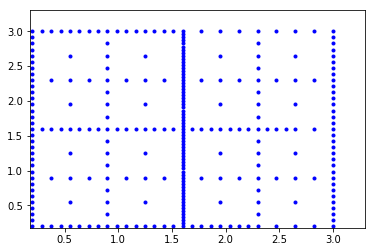

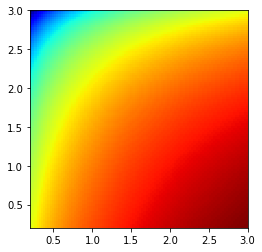

 
(' Computation of a growth model of dimension ', 2, ' finished after ', 10, ' steps')
 
 
 Errors are computed -- see errors.txt
 


In [44]:
#======================================================================
# Start with Value Function Iteration

# terminal value function
valnew=TasmanianSG.TasmanianSparseGrid()
if (numstart==0):
    print("VF Initialization:", numstart)
    #valnew=interpol.sparse_grid(n_agents, iDepth)
    #valnew=sparse_grid(n_agents, iDepth)
    valnew=adap_sparse_grid(n_agents, iDepth)
    valnew.write("valnew_1." + str(numstart) + ".txt") #write file to disk for restart

# value function during iteration
else:
    valnew.read("valnew_1." + str(numstart) + ".txt")  #write file to disk for restart
    
valold=TasmanianSG.TasmanianSparseGrid()
valold=valnew

for i in range(numstart, numits):
    print("Iteration number:", i+1)
    valnew=TasmanianSG.TasmanianSparseGrid()
    #valnew=interpol_iter.sparse_grid_iter(n_agents, iDepth, valold)
    #valnew=sparse_grid_iter(n_agents, iDepth, valold)
    valnew=adap_sparse_grid_iter(n_agents, iDepth, valold,i,numits)
    valold=TasmanianSG.TasmanianSparseGrid()
    valold=valnew
    valnew.write("valnew_1." + str(i+1) + ".txt")    
    
#======================================================================
print( "===============================================================")
print( " " )
print( " Computation of a growth model of dimension ", n_agents ," finished after ", numits, " steps")
print( " " )
print( "===============================================================")
#======================================================================

# compute errors   
avg_err=post.ls_error(n_agents, numstart, numits, No_samples)

#======================================================================
print( "===============================================================")
print( " ")
print( " Errors are computed -- see errors.txt")
print( " ")
print( "===============================================================")
#======================================================================